In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -r requirements.txt

In [3]:
# Imports
import string
import re
import random
import csv

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchtext
from torchtext.legacy import data
from torchtext.data.metrics import bleu_score
import pandas as pd
import time
import math
import numpy as np

# Plotting
# for colab
%matplotlib inline 
# for local notebook
# %matplotlib notebook 
import matplotlib.pyplot as plt

from dataset import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [5]:
def sentence_to_index(sentence, stoi) :
    return [stoi.get(ch) if ch in stoi else stoi['<UNK>'] for ch in sentence]

def index_to_sentence(indices, itos) :
    return [itos[id] for id in indices]    

In [6]:
class TwitterDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: torchtext.vocab.Vocab) -> None:
        super().__init__()
        self.df = df
        self.vocab = vocab
        self.vocab_stoi = vocab.get_stoi()
        self.vocab_itos = vocab.get_itos()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> torch.Tensor:
        sample = self.df.iloc[index]
        tweet = sample['text']
        tweet_ch = ['<BOS>'] + tweet.strip().split() + ['<EOS>']
        tweet_indices = sentence_to_index(tweet_ch, self.vocab_stoi)
        tweet_tensor = torch.tensor(tweet_indices, dtype=torch.long).unsqueeze(0)

        return tweet_tensor

In [7]:
# https://github.com/stanfordnlp/GloVe

def load_glove() :
    words = []
    idx = 0
    word2idx = {}
    vectors = []

    with open('glove.6B.50d.txt', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            words.append(word)
            word2idx[word] = idx
            idx += 1
            vect = np.array(line[1:]).astype(np.float)
            vectors.append(vect)

            if not idx % 100000 :
                print(idx, 'loaded')

    glove = {w: vectors[word2idx[w]] for w in words}

    return vectors

In [129]:
class TextGenerator(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1, use_embeds=False):
        super(TextGenerator, self).__init__()
        # self.use_embeds = use_embeds
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.encoder = nn.Embedding(self.vocab_size, self.hidden_size)

        if use_embeds :
            glove_embeddings = torch.tensor(np.array(load_glove()), dtype=torch.float)
            self.encoder = nn.Embedding.from_pretrained(glove_embeddings)
            self.hidden_size = glove_embeddings.shape[1]

        self.rnn = nn.GRU(
            self.hidden_size,
            self.hidden_size,
            self.num_layers,
            batch_first=True
        )
        self.decoder = nn.Linear(self.hidden_size, self.vocab_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input)              # encode input using embedding layer
        output, hidden = self.rnn(input, hidden) # get the next output and hidden state
        output = self.decoder(output)            # predict distribution over next tokens
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [130]:
def sample_sequence(model, vocab, start_sequence=["<BOS>"], max_len=100, temperature=0.8):
    generated_sequence = ""
    vocab_stoi = vocab.get_stoi()
    vocab_itos = vocab.get_itos()
    inputs = torch.tensor(sentence_to_index(start_sequence, vocab_stoi), dtype=torch.long, device=device)
    hidden = model.init_hidden(1)
    for p in range(max_len):
        output, hidden = model(inputs.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i] # if top_i in range(len(vocab_itos)) else "UNK"
        
        if predicted_char == "<EOS>":
            break
        generated_sequence += predicted_char + " "      
        inputs = torch.tensor([top_i], dtype=torch.long, device=device)
    return generated_sequence

In [131]:
df = load_dataset('cnn')
tweets = df['text'].apply(lambda x: x.strip().split()).tolist()
special_tokens = ['<BOS>', '<EOS>', '<UNK>']
vocab = torchtext.vocab.build_vocab_from_iterator(tweets,
                                                  min_freq=2,
                                                  specials=special_tokens)
vocab_stoi = vocab.get_stoi()
vocab_itos = vocab.get_itos()
vocab_size = len(vocab)
dataset = TwitterDataset(df, vocab)

/home/cvxluo/Documents/Projects/Alive/nlp-4650-project/dataset.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filter]


In [132]:
example = dataset[5].squeeze()
print(index_to_sentence(example, vocab_itos))

['<BOS>', 'Family', 'lawyer:', 'Michigan', 'man', 'shot', 'by', 'U.S.', 'forces', 'in', 'Iraq', '2', '<EOS>']


In [133]:
def train(model, iterator, vocab, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    model.zero_grad()

    candidates = []
    references = []
    
    losses = []
    bleu_scores = []
    perplexities = []

    for e in range(num_epochs):
        # get training set
        avg_loss = 0
        avg_perplexity = 0
        hidden = model.init_hidden(batch_size)

        for tweet in iterator:
            tweet = tweet.view(1, -1).to(device)
            target = tweet[:, 1:]
            input = tweet[:, :-1]

            # cleanup
            optimizer.zero_grad()
            # forward pass
            output, hidden = model(input, hidden)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            hidden = hidden.detach()

            # backward pass
            loss.backward()
            optimizer.step()

            avg_loss += loss
            avg_perplexity += math.exp(loss)
            it += 1 # increment iteration count
            if it % print_every == 0:
                '''
                # BLEU score calculation
                candidates = [sample_sequence(model, vocab, temperature=0.6).split()] # for i in range(3)]
                reference_corp = list(map(lambda ids : index_to_sentence(ids.squeeze(), vocab_itos), iterator))
                references = [reference_corp] # for i in range(3)]
                bleu = bleu_score(candidate_corpus=candidates, references_corpus=references, max_n=4)
                '''
                bleu = 0

                print("[Epoch %d Iter %d] Loss %f, BLEU %f" % (e+1, it+1, float(avg_loss/print_every), bleu))
                print("    " + sample_sequence(model, vocab))
                losses.append(avg_loss.item())
                bleu_scores.append(bleu)
                perplexities.append(avg_perplexity)
                avg_perplexity = 0
                avg_loss = 0


    return losses, bleu_scores, perplexities

In [134]:
hidden_size = 256
n_layers = 1
batch_size = 1
lr = 0.001
num_epochs = 10
USE_EMBEDS = True
# Note that if we use pretrained embeddings, our hidden size parameter will be ignored

data_iterator = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = TextGenerator(vocab_size, hidden_size, n_layers=n_layers, use_embeds=USE_EMBEDS).to(device)

100000 loaded
200000 loaded
300000 loaded
400000 loaded


In [128]:
avg_losses, bleu_scores, perplexities = train(model, data_iterator, vocab, batch_size=batch_size, num_epochs=num_epochs, lr=lr, print_every=500)

01,  1.0209e+00],
         [-6.1106e-02,  9.2698e-01, -2.4740e-02, -8.2404e-01,  3.5838e-01,
           5.1235e-01, -1.7368e+00, -7.7074e-02, -5.2803e-01, -9.1106e-01,
          -8.9816e-01,  1.3488e+00, -5.2135e-01, -6.8333e-01, -6.1652e-05,
          -2.2163e-01,  3.4219e-02, -8.0921e-01, -1.0316e+00, -3.3231e-01,
          -2.6263e-01,  2.1177e-01, -1.6616e-01, -6.3857e-01,  5.6367e-02,
          -1.8269e+00, -1.9825e-01, -9.0269e-01, -7.0902e-01,  5.5313e-01,
           1.7004e+00, -7.5809e-01,  5.5337e-03, -6.1740e-01,  5.4148e-01,
          -4.1653e-01,  2.9324e-01, -2.4988e-01,  2.9099e-01, -4.1196e-01,
           5.5186e-01,  1.1609e+00, -1.0677e+00, -2.3122e-01,  2.8835e-01,
           7.2285e-01, -5.9046e-01, -9.2790e-01, -8.2795e-01,  1.0663e+00],
         [ 3.9119e-01,  3.4992e-01,  2.2498e-01,  1.1417e-01,  3.1087e-01,
          -5.2257e-01, -9.2955e-01,  2.5335e-01, -8.9138e-02, -4.2545e-01,
          -3.1354e-01, -4.5698e-01, -6.4173e-01,  3.1926e-01,  1.0812e+00,
      

KeyboardInterrupt: 

In [14]:
print(sample_sequence(model, vocab, temperature=0.6))

<UNK> 


In [18]:
start = input()
print(start + " " + sample_sequence(model, vocab, start_sequence=start.split(), temperature=0.6))

Space Station planned for 1 


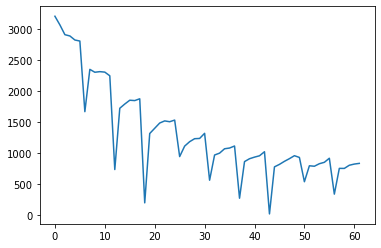

In [20]:
plt.plot(avg_losses)

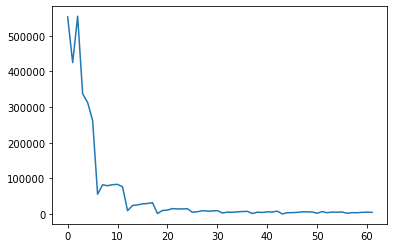

In [21]:
plt.plot(perplexities)